In [1]:
import math
import numpy as np
import pandas as pd

from sklearn.ensemble import gradient_boosting
from sklearn.tree import plot_tree

# Classification

## Dataset

In [2]:
df = pd.DataFrame({"x":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                   "y":[0, 0, 0, 1, 1, 0, 0, 0, 1, 1]})

## Helper functions

In [3]:
def init_cls(df):
    """
    Initialize a classification tree with F0(x)
    
    Args:
        df (DataFrame): The input DataFrame    
    
    Returns:
        tree (DataFrame): The output DataFrame 
    """
    f_0 = math.log((df["y"] == 1).sum() / (df["y"] == 0).sum()) # ln(p/1-p)
    
    tree = df.copy()
    tree["f0"] = f_0
    return tree

In [4]:
def calc_res_cls(df, f_col_name):
    """
    Convert F(x) to proba & calculate pseudo-residual
    
    Args:
        df (DataFrame): The input DataFrame
        f_col_name (str): A column of F(x)
        
    Returns:
        df (DataFrame): The output DataFrame with calculated results
    """
    df["%s_proba"%f_col_name] = 1 / (1 + np.exp(-1 * df[f_col_name])) # F(x) -> proba
    df["res_%s"%f_col_name] = df["y"] - df["%s_proba"%f_col_name] # y - F(x)
    return df

In [5]:
def split_cls(df, feat_col, thres_ls, res_col):
    """
    Calculate Square Error to select the best split point
    
    Args:
        df (DataFrame): The input DataFrame
        feat_col (str): The feature column to split
        thres_ls (list): A list of split points
        res_col (str): A column of pseudo-residual
        
    Returns:
        split_thres (float): The split point
        left_mse (float): The MSE of all left nodes
        right_mse (float): The MSE of all right nodes
    """
    sp = []
    se_ls = []
    l_mse_ls = []
    r_mse_ls = []
    
    for thres in thres_ls:
        left = df[df[feat_col] <= thres]
        right = df[df[feat_col] > thres]

        left_se = (left[res_col] - left[res_col].mean()) ** 2
        right_se = (right[res_col] - right[res_col].mean()) ** 2

        se_sum = np.sum(left_se) + np.sum(right_se)
        
        sp.append(thres)
        se_ls.append(se_sum)
        l_mse_ls.append(np.mean(left_se))
        r_mse_ls.append(np.mean(right_se))
        
    sp_arr = np.array([sp, se_ls, l_mse_ls, r_mse_ls])
    split_thres = sp[np.argmin(sp_arr[1])] # split threshold
    left_mse = l_mse_ls[np.argmin(sp_arr[1])] # left nodes MSE
    right_mse = r_mse_ls[np.argmin(sp_arr[1])] # right nodes MSE
    return split_thres, left_mse, right_mse

In [6]:
def leaf_val_cls(df, feat_col, res_col, thres):
    """
    Calculate leaf node value
    
    Args:
        df (DataFrame): The input DataFrame
        feat_col (str): The feature column to split
        res_col (str): A column of pseudo-residual
        thres (float): The split point
    
    Returns:
        left_leaf_value (flaot): Left leaf node values
        right_leaf_value (flaot): Right leaf node values
    """
    left_numerator  = df[df[feat_col] <= thres][res_col].sum()
    left_denominator = (df[df[feat_col] <= thres].apply(
        lambda r: (r["y"] - r[res_col]) * (1 - r["y"] + r[res_col]), axis=1)).sum()
    
    right_numerator  = df[df[feat_col] > thres][res_col].sum()
    right_denominator = (df[df[feat_col] > thres].apply(
        lambda r: (r["y"] - r[res_col]) * (1 - r["y"] + r[res_col]), axis=1)).sum()
    
    left_leaf_value = left_numerator / left_denominator
    right_leaf_value = right_numerator / right_denominator
    
    return left_leaf_value, right_leaf_value

## Here we go

### 1. Initialization

In [7]:
tree = init_cls(df)
tree

,x,y,f0
0,1,0,-0.405465
1,2,0,-0.405465
2,3,0,-0.405465
3,4,1,-0.405465
4,5,1,-0.405465
5,6,0,-0.405465
6,7,0,-0.405465
7,8,0,-0.405465
8,9,1,-0.405465
9,10,1,-0.405465


### 2. Calc proba & pseudo-residual

In [8]:
tree = calc_res_cls(tree, "f0")
tree

,x,y,f0,f0_proba,res_f0
0,1,0,-0.405465,0.4,-0.4
1,2,0,-0.405465,0.4,-0.4
2,3,0,-0.405465,0.4,-0.4
3,4,1,-0.405465,0.4,0.6
4,5,1,-0.405465,0.4,0.6
5,6,0,-0.405465,0.4,-0.4
6,7,0,-0.405465,0.4,-0.4
7,8,0,-0.405465,0.4,-0.4
8,9,1,-0.405465,0.4,0.6
9,10,1,-0.405465,0.4,0.6


### 3. Find the split point

In [9]:
thres, left_mse, right_mse = split_cls(tree, "x", np.arange(0.5, 11.5, 1), "res_f0")
print("The split point is:", thres)
print("After split, the MSE of pseudo-residual on left:", left_mse)
print("After split, the MSE of pseudo-residual on right:", right_mse)

The split point is: 8.5
After split, the MSE of pseudo-residual on left: 0.1875
After split, the MSE of pseudo-residual on right: 0.0


### 4. Calc leaf node values

In [10]:
left_value, right_value = leaf_val_cls(tree, "x", "res_f0", thres)
print("Left value:", left_value)
print("Right value:", right_value)

Left value: -0.6250000000000001
Right value: 2.5


### 5. Update F(x)

```F1(x) = F0(x) + lr * f1(x)```

In [11]:
lr = 0.1 # learning rate

In [12]:
tree["f1"] = np.where(tree["x"] <= thres, 
                      tree["f0"] + left_value * lr, 
                      tree["f0"] + right_value * lr)

In [13]:
tree

,x,y,f0,f0_proba,res_f0,f1
0,1,0,-0.405465,0.4,-0.4,-0.467965
1,2,0,-0.405465,0.4,-0.4,-0.467965
2,3,0,-0.405465,0.4,-0.4,-0.467965
3,4,1,-0.405465,0.4,0.6,-0.467965
4,5,1,-0.405465,0.4,0.6,-0.467965
5,6,0,-0.405465,0.4,-0.4,-0.467965
6,7,0,-0.405465,0.4,-0.4,-0.467965
7,8,0,-0.405465,0.4,-0.4,-0.467965
8,9,1,-0.405465,0.4,0.6,-0.155465
9,10,1,-0.405465,0.4,0.6,-0.155465


### Repeat for several steps

In [14]:
tree = calc_res_cls(tree, "f1")
tree

,x,y,f0,f0_proba,res_f0,f1,f1_proba,res_f1
0,1,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
1,2,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
2,3,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
3,4,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902
4,5,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902
5,6,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
6,7,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
7,8,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
8,9,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788
9,10,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788


In [15]:
thres, left_mse, right_mse = split_cls(tree, "x", np.arange(0.5, 11.5, 1), "res_f1")
print("The split point is:", thres)
print("After split, the MSE of pseudo-residual on left:", left_mse)
print("After split, the MSE of pseudo-residual on right:", right_mse)

The split point is: 8.5
After split, the MSE of pseudo-residual on left: 0.1875
After split, the MSE of pseudo-residual on right: 0.0


In [16]:
left_value, right_value = leaf_val_cls(tree, "x", "res_f1", thres)
print("Left value:", left_value)
print("Right value:", right_value)

Left value: -0.5705211093125406
Right value: 2.1682011746071073


In [17]:
tree["f2"] = np.where(tree["x"] <= thres, 
                      tree["f1"] + left_value * lr, 
                      tree["f1"] + right_value * lr)

In [18]:
tree = calc_res_cls(tree, "f2")
tree

,x,y,f0,f0_proba,res_f0,f1,f1_proba,res_f1,f2,f2_proba,res_f2
0,1,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
1,2,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
2,3,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
3,4,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902,-0.525017,0.371680,0.628320
4,5,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902,-0.525017,0.371680,0.628320
5,6,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
6,7,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
7,8,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
8,9,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788,0.061355,0.515334,0.484666
9,10,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788,0.061355,0.515334,0.484666


In [19]:
thres, left_mse, right_mse = split_cls(tree, "x", np.arange(0.5, 11.5, 1), "res_f2")
print("The split point is:", thres)
print("After split, the MSE of pseudo-residual on left:", left_mse)
print("After split, the MSE of pseudo-residual on right:", right_mse)

The split point is: 3.5
After split, the MSE of pseudo-residual on left: 0.0
After split, the MSE of pseudo-residual on right: 0.21392888430746773


In [20]:
left_value, right_value = leaf_val_cls(tree, "x", "res_f2", thres)
print("Left value:", left_value)
print("Right value:", right_value)

Left value: -1.591545178439374
Right value: 0.6663469228422207


In [21]:
tree["f3"] = np.where(tree["x"] <= thres, 
                      tree["f2"] + left_value * lr, 
                      tree["f2"] + right_value * lr)

In [22]:
tree = calc_res_cls(tree, "f3")
tree

,x,y,f0,f0_proba,res_f0,f1,f1_proba,res_f1,f2,f2_proba,res_f2,f3,f3_proba,res_f3
0,1,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680,-0.684172,0.335331,-0.335331
1,2,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680,-0.684172,0.335331,-0.335331
2,3,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680,-0.684172,0.335331,-0.335331
3,4,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902,-0.525017,0.371680,0.628320,-0.458383,0.387370,0.612630
4,5,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902,-0.525017,0.371680,0.628320,-0.458383,0.387370,0.612630
5,6,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680,-0.458383,0.387370,-0.387370
6,7,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680,-0.458383,0.387370,-0.387370
7,8,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680,-0.458383,0.387370,-0.387370
8,9,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788,0.061355,0.515334,0.484666,0.127990,0.531954,0.468046
9,10,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788,0.061355,0.515334,0.484666,0.127990,0.531954,0.468046


## Let's check with GBDT in sklearn

### 1. The output of the model

In [23]:
clf_1 = gradient_boosting.GradientBoostingClassifier(n_estimators=3, max_depth=1)

In [24]:
clf_1.fit(df[["x"]], df["y"])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=3,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [25]:
clf_1.predict_proba(df[["x"]])[:, 1]

array([0.33533085, 0.33533085, 0.33533085, 0.3873696 , 0.3873696 ,
       0.3873696 , 0.3873696 , 0.3873696 , 0.53195382, 0.53195382])

### 2. Plot these trees

In [26]:
plot_tree(clf_1.estimators_[0][0]) # 1st tree (split at 8.5)

[Text(248.0, 277.2, 'X[0] <= 8.5\nfriedman_mse = 0.24\nsamples = 10\nvalue = -0.0'),
 Text(124.0, 92.39999999999998, 'friedman_mse = 0.188\nsamples = 8\nvalue = -0.625'),
 Text(372.0, 92.39999999999998, 'friedman_mse = -0.0\nsamples = 2\nvalue = 2.5')]

[Text(167.4, 163.07999999999998, 'X[0] <= 8.5\nfriedman_mse = 0.223\nsamples = 10\nvalue = -0.0'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.187\nsamples = 8\nvalue = -0.571'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = 0.0\nsamples = 2\nvalue = 2.168')]

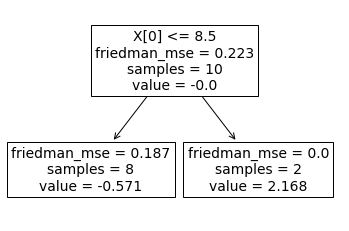

In [27]:
plot_tree(clf_1.estimators_[1][0]) # 2nd tree (split at 8.5)

[Text(167.4, 163.07999999999998, 'X[0] <= 3.5\nfriedman_mse = 0.209\nsamples = 10\nvalue = -0.0'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.0\nsamples = 3\nvalue = -1.592'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = 0.214\nsamples = 7\nvalue = 0.666')]

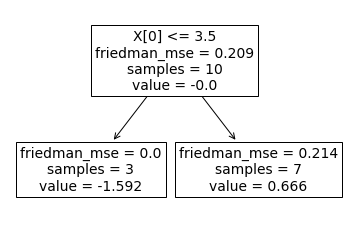

In [28]:
plot_tree(clf_1.estimators_[2][0]) # 3rd tree (split at 3.5)

# Regression

## Dataset

In [29]:
df2 = pd.DataFrame({"x":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                    "y":[5.56, 5.7, 5.91, 6.4, 6.8, 7.05, 8.9, 8.7, 9, 9.05]})

## Helper functions

In [30]:
def init_reg(df):
    """
    Initialize a regression tree with F0(x)
    
    Args:
        df (DataFrame): The input DataFrame    
    
    Returns:
        tree (DataFrame): The output DataFrame 
    """
    f_0 = df["y"].mean() # simple average
    
    tree = df.copy()
    tree["f0"] = f_0
    return tree

In [31]:
def calc_res_reg(df, f_col_name):
    """
    Calculate pseudo-residual
    
    Args:
        df (DataFrame): The input DataFrame
        f_col_name (str): A column of F(x), which is the prediction for regression
        
    Returns:
        df (DataFrame): The output DataFrame with calculated results
    """
    df["res_%s"%f_col_name] = df["y"] - df[f_col_name] # y - F(x)
    return df

In [32]:
split_reg = split_cls # split point search is the same with classification

In [33]:
def leaf_val_reg(df, feat_col, res_col, thres):
    """
    Calculate leaf node value (Newton-Raphson method)
    
    Args:
        df (DataFrame): The input DataFrame
        feat_col (str): The feature column to split
        res_col (str): A column of pseudo-residual
        thres (float): The split point
    
    Returns:
        left_leaf_value (flaot): Left leaf node values
        right_leaf_value (flaot): Right leaf node values
    """
    left_leaf_value = df[df[feat_col] <= thres][res_col].mean()
    right_leaf_value = df[df[feat_col] > thres][res_col].mean()
    
    return left_leaf_value, right_leaf_value

## Here we go

### 1. Initialization

In [34]:
tree2 = init_reg(df2)
tree2

,x,y,f0
0,1,5.56,7.307
1,2,5.70,7.307
2,3,5.91,7.307
3,4,6.40,7.307
4,5,6.80,7.307
5,6,7.05,7.307
6,7,8.90,7.307
7,8,8.70,7.307
8,9,9.00,7.307
9,10,9.05,7.307


### 2. Calc pseudo-residual

In [35]:
tree2 = calc_res_reg(tree2, "f0")
tree2

,x,y,f0,res_f0
0,1,5.56,7.307,-1.747
1,2,5.70,7.307,-1.607
2,3,5.91,7.307,-1.397
3,4,6.40,7.307,-0.907
4,5,6.80,7.307,-0.507
5,6,7.05,7.307,-0.257
6,7,8.90,7.307,1.593
7,8,8.70,7.307,1.393
8,9,9.00,7.307,1.693
9,10,9.05,7.307,1.743


### 3. Find the split point

In [36]:
thres, left_mse, right_mse = split_reg(tree2, "x", np.arange(0.5, 11.5, 1), "res_f0")
print("The split point is:", thres)
print("After split, the MSE of pseudo-residual on left:", left_mse)
print("After split, the MSE of pseudo-residual on right:", right_mse)

The split point is: 6.5
After split, the MSE of pseudo-residual on left: 0.30968888888888885
After split, the MSE of pseudo-residual on right: 0.017968750000000124


### 4. Calc leaf node values

In [37]:
left_value, right_value = leaf_val_reg(tree2, "x", "res_f0", thres)
print("Left value:", left_value)
print("Right value:", right_value)

Left value: -1.070333333333333
Right value: 1.6055000000000006


### 5. Update F(x)

```F1(x) = F0(x) + lr * f1(x)```

In [38]:
lr = 0.1 # learning rate

In [39]:
tree2["f1"] = np.where(tree2["x"] <= thres, 
                       tree2["f0"] + left_value * lr, 
                       tree2["f0"] + right_value * lr)

In [40]:
tree2

,x,y,f0,res_f0,f1
0,1,5.56,7.307,-1.747,7.199967
1,2,5.70,7.307,-1.607,7.199967
2,3,5.91,7.307,-1.397,7.199967
3,4,6.40,7.307,-0.907,7.199967
4,5,6.80,7.307,-0.507,7.199967
5,6,7.05,7.307,-0.257,7.199967
6,7,8.90,7.307,1.593,7.467550
7,8,8.70,7.307,1.393,7.467550
8,9,9.00,7.307,1.693,7.467550
9,10,9.05,7.307,1.743,7.467550


### Repeat for several steps

In [41]:
tree2 = calc_res_reg(tree2, "f1")
tree2

,x,y,f0,res_f0,f1,res_f1
0,1,5.56,7.307,-1.747,7.199967,-1.639967
1,2,5.70,7.307,-1.607,7.199967,-1.499967
2,3,5.91,7.307,-1.397,7.199967,-1.289967
3,4,6.40,7.307,-0.907,7.199967,-0.799967
4,5,6.80,7.307,-0.507,7.199967,-0.399967
5,6,7.05,7.307,-0.257,7.199967,-0.149967
6,7,8.90,7.307,1.593,7.467550,1.432450
7,8,8.70,7.307,1.393,7.467550,1.232450
8,9,9.00,7.307,1.693,7.467550,1.532450
9,10,9.05,7.307,1.743,7.467550,1.582450


In [42]:
thres, left_mse, right_mse = split_reg(tree2, "x", np.arange(0.5, 11.5, 1), "res_f1")
print("The split point is:", thres)
print("After split, the MSE of pseudo-residual on left:", left_mse)
print("After split, the MSE of pseudo-residual on right:", right_mse)

The split point is: 6.5
After split, the MSE of pseudo-residual on left: 0.3096888888888889
After split, the MSE of pseudo-residual on right: 0.017968750000000124


In [43]:
left_value, right_value = leaf_val_reg(tree2, "x", "res_f1", thres)
print("Left value:", left_value)
print("Right value:", right_value)

Left value: -0.9632999999999999
Right value: 1.4449500000000008


In [44]:
tree2["f2"] = np.where(tree2["x"] <= thres, 
                       tree2["f1"] + left_value * lr, 
                       tree2["f1"] + right_value * lr)

In [45]:
tree2 = calc_res_reg(tree2, "f2")
tree2

,x,y,f0,res_f0,f1,res_f1,f2,res_f2
0,1,5.56,7.307,-1.747,7.199967,-1.639967,7.103637,-1.543637
1,2,5.70,7.307,-1.607,7.199967,-1.499967,7.103637,-1.403637
2,3,5.91,7.307,-1.397,7.199967,-1.289967,7.103637,-1.193637
3,4,6.40,7.307,-0.907,7.199967,-0.799967,7.103637,-0.703637
4,5,6.80,7.307,-0.507,7.199967,-0.399967,7.103637,-0.303637
5,6,7.05,7.307,-0.257,7.199967,-0.149967,7.103637,-0.053637
6,7,8.90,7.307,1.593,7.467550,1.432450,7.612045,1.287955
7,8,8.70,7.307,1.393,7.467550,1.232450,7.612045,1.087955
8,9,9.00,7.307,1.693,7.467550,1.532450,7.612045,1.387955
9,10,9.05,7.307,1.743,7.467550,1.582450,7.612045,1.437955


In [46]:
thres, left_mse, right_mse = split_reg(tree2, "x", np.arange(0.5, 11.5, 1), "res_f2")
print("The split point is:", thres)
print("After split, the MSE of pseudo-residual on left:", left_mse)
print("After split, the MSE of pseudo-residual on right:", right_mse)

The split point is: 6.5
After split, the MSE of pseudo-residual on left: 0.3096888888888889
After split, the MSE of pseudo-residual on right: 0.017968750000000124


In [47]:
left_value, right_value = leaf_val_reg(tree2, "x", "res_f2", thres)
print("Left value:", left_value)
print("Right value:", right_value)

Left value: -0.8669699999999999
Right value: 1.3004550000000008


In [48]:
tree2["f3"] = np.where(tree2["x"] <= thres, 
                       tree2["f2"] + left_value * lr, 
                       tree2["f2"] + right_value * lr)

In [49]:
tree2 = calc_res_reg(tree2, "f3")
tree2

,x,y,f0,res_f0,f1,res_f1,f2,res_f2,f3,res_f3
0,1,5.56,7.307,-1.747,7.199967,-1.639967,7.103637,-1.543637,7.01694,-1.456940
1,2,5.70,7.307,-1.607,7.199967,-1.499967,7.103637,-1.403637,7.01694,-1.316940
2,3,5.91,7.307,-1.397,7.199967,-1.289967,7.103637,-1.193637,7.01694,-1.106940
3,4,6.40,7.307,-0.907,7.199967,-0.799967,7.103637,-0.703637,7.01694,-0.616940
4,5,6.80,7.307,-0.507,7.199967,-0.399967,7.103637,-0.303637,7.01694,-0.216940
5,6,7.05,7.307,-0.257,7.199967,-0.149967,7.103637,-0.053637,7.01694,0.033060
6,7,8.90,7.307,1.593,7.467550,1.432450,7.612045,1.287955,7.74209,1.157910
7,8,8.70,7.307,1.393,7.467550,1.232450,7.612045,1.087955,7.74209,0.957909
8,9,9.00,7.307,1.693,7.467550,1.532450,7.612045,1.387955,7.74209,1.257910
9,10,9.05,7.307,1.743,7.467550,1.582450,7.612045,1.437955,7.74209,1.307910


## Let's check with GBRT in sklearn

### 1. The output of the model

In [50]:
reg_1 = gradient_boosting.GradientBoostingRegressor(n_estimators=3, max_depth=1)

In [51]:
reg_1.fit(df2[["x"]], df2["y"])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [52]:
reg_1.predict(df2[["x"]])

array([7.01693967, 7.01693967, 7.01693967, 7.01693967, 7.01693967,
       7.01693967, 7.7420905 , 7.7420905 , 7.7420905 , 7.7420905 ])

### 2. Plot these trees

[Text(167.4, 163.07999999999998, 'X[0] <= 6.5\nfriedman_mse = 1.911\nsamples = 10\nvalue = -0.0'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.31\nsamples = 6\nvalue = -1.07'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = 0.018\nsamples = 4\nvalue = 1.605')]

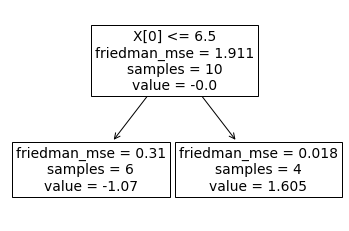

In [53]:
plot_tree(reg_1.estimators_[0][0]) # 1st tree (split at 6.5)

[Text(167.4, 163.07999999999998, 'X[0] <= 6.5\nfriedman_mse = 1.585\nsamples = 10\nvalue = 0.0'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.31\nsamples = 6\nvalue = -0.963'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = 0.018\nsamples = 4\nvalue = 1.445')]

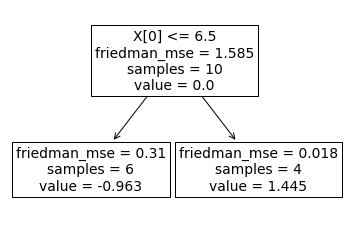

In [54]:
plot_tree(reg_1.estimators_[1][0]) # 2nd tree (split at 6.5)

[Text(167.4, 163.07999999999998, 'X[0] <= 6.5\nfriedman_mse = 1.32\nsamples = 10\nvalue = 0.0'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.31\nsamples = 6\nvalue = -0.867'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = 0.018\nsamples = 4\nvalue = 1.3')]

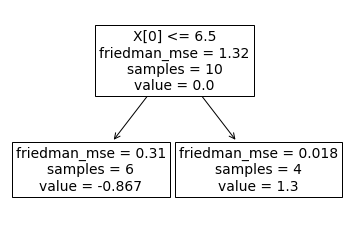

In [55]:
plot_tree(reg_1.estimators_[2][0]) # 3rd tree (split at 6.5)